In [186]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load datasets
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

# Remove unnecessary columns
train_df.drop(columns=["ID", "Var_1"], inplace=True)
test_df.drop(columns=["ID", "Var_1"], inplace=True)

### 1) Handling Missing Values Intelligently ###
# Calculate missing value percentage for each column
missing_percent = (train_df.isnull().sum() / len(train_df)) * 100
print("Missing values percentage:\n", missing_percent)

# Define a threshold (e.g., 5%) for deciding whether to drop or impute
threshold = 5

# Separate numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
categorical_cols = train_df.select_dtypes(include=[object]).columns

# Handle missing values
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:  # If there are missing values
        if missing_percent[col] > threshold:
            if col in numerical_cols:  # Numerical features
                train_df[col].fillna(train_df[col].median(), inplace=True)
            elif col in categorical_cols:  # Categorical features
                train_df[col].fillna(train_df[col].mode()[0], inplace=True)
        else:
            train_df.dropna(subset=[col], inplace=True)  # Drop entire row if missing < threshold

# Apply the same strategy to test data but without dropping rows
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        if col in numerical_cols:
            median_value = train_df[col].median()  # Use median from training data
            test_df[col].fillna(median_value, inplace=True)
        elif col in categorical_cols:
            mode_value = train_df[col].mode()[0]  # Use mode from training data
            test_df[col].fillna(mode_value, inplace=True)

# Display missing values after handling
print("Missing values after handling:\n", train_df.isnull().sum())

### 2) Removing Outliers (Using IQR Method) ###
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to numerical columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    train_df = remove_outliers(train_df, col)


### 3) Encoding Categorical Features ###
# List of binary categorical columns for Label Encoding
binary_cols = ["Gender", "Ever_Married", "Graduated"]

# List of multi-category columns for One-Hot Encoding
one_hot_cols = ["Profession"]

# Apply Label Encoding
label_encoders = {}
for col in binary_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])  # Ensure consistency
    label_encoders[col] = le

# Manually encode Spending_Score
spending_mapping = {"Low": 0, "Average": 1, "High": 2}
train_df["Spending_Score"] = train_df["Spending_Score"].map(spending_mapping)
test_df["Spending_Score"] = test_df["Spending_Score"].map(spending_mapping)

# Apply One-Hot Encoding for remaining categorical columns
train_df = pd.get_dummies(train_df, columns=one_hot_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=one_hot_cols, drop_first=True)

# Display processed data
print(train_df.head())
print(test_df.head())

Missing values percentage:
 Gender              0.000000
Ever_Married        1.735250
Age                 0.000000
Graduated           0.966782
Profession          1.536936
Work_Experience    10.275161
Spending_Score      0.000000
Family_Size         4.152206
Segmentation        0.000000
dtype: float64
Missing values after handling:
 Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Segmentation       0
dtype: int64
   Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
0       1             0   22          0              1.0               0   
1       0             1   38          1              1.0               1   
2       0             1   67          1              1.0               0   
3       1             1   67          1              0.0               2   
4       0             1   40          1              1.0               2   

   Fa

<ipython-input-186-29e6f9998461>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
<ipython-input-186-29e6f9998461>:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [191]:
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode target variable
target_encoder = LabelEncoder()
train_df["Segmentation"] = target_encoder.fit_transform(train_df["Segmentation"])
test_df["Segmentation"] = target_encoder.fit_transform(test_df["Segmentation"])

# Generate Initial Population
def generate_population(features, population_size, max_features):
    return [random.sample(features, k=max_features) for _ in range(population_size)]

# Fitness Function
def fitness_function(individual, X, y):
    if not individual:
        return 0  # Avoid empty feature selection

    X_subset = X[individual]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred)

# Selection Methods
def tournament_selection(population, scores, k=3):
    selected = random.sample(list(zip(population, scores)), k)
    return max(selected, key=lambda x: x[1])[0]

def roulette_wheel_selection(population, scores):
    total_fitness = sum(scores)
    if total_fitness == 0:
        return random.choice(population)  # Avoid division by zero
    probabilities = [f / total_fitness for f in scores]
    return random.choices(population, weights=probabilities, k=1)[0]

def multi_point_crossover(parent1, parent2, max_features, num_points=2):
    child1, child2 = parent1.copy(), parent2.copy()

    if len(parent1) < num_points or len(parent2) < num_points:
        return parent1, parent2


    crossover_points = sorted(random.sample(range(len(parent1)), num_points))
    start, end = crossover_points


    child1[start:end], child2[start:end] = child2[start:end], child1[start:end]


    child1 = fix_duplicates(child1, parent1, max_features)
    child2 = fix_duplicates(child2, parent2, max_features)

    return child1, child2

def uniform_crossover(parent1, parent2, max_features):
    child1, child2 = [], []

    for g1, g2 in zip(parent1, parent2):
        if random.random() > 0.5:
            child1.append(g1)
            child2.append(g2)
        else:
            child1.append(g2)
            child2.append(g1)

    # Fix duplicates and ensure max_features limit
    child1 = fix_duplicates(child1, parent1, max_features)
    child2 = fix_duplicates(child2, parent2, max_features)

    return child1, child2


def fix_duplicates(child, parent, max_features):

    unique_features = set()
    new_child = []

    for feature in child:
        if feature not in unique_features:
            unique_features.add(feature)
            new_child.append(feature)

    missing_features = [f for f in parent if f not in new_child]
    new_child.extend(missing_features[:max_features - len(new_child)])

    return new_child[:max_features]


# Mutation Operator
def mutation(individual, features, max_features, mutation_rate=0.05):
    if random.random() < mutation_rate:
        idx = random.randint(0, len(individual) - 1)
        possible_new_features = list(set(features) - set(individual))
        if possible_new_features:
            new_feature = random.choice(possible_new_features)
            individual[idx] = new_feature

    return individual[:max_features]

# Genetic Algorithm Implementation with Convergence Criterion
def genetic_algorithm(X, y, features, max_features, population_size=15, generations=100, mutation_rate=0.0625, patience=20, improvement_threshold=0.001):
    population = generate_population(features, population_size, max_features)
    best_score = 0
    no_improvement_count = 0  # Tracks how many consecutive generations had no significant improvement

    for generation in range(generations):
        scores = [fitness_function(ind, X, y) for ind in population]
        new_population = []

        for _ in range(population_size // 2):
            parent1 = tournament_selection(population, scores)
            parent2 = tournament_selection(population, scores)

            child1, child2 = multi_point_crossover(parent1, parent2, max_features)
            child1, child2 = mutation(child1, features, max_features, mutation_rate), mutation(child2, features, max_features, mutation_rate)

            new_population.extend([child1, child2])

        population = new_population
        current_best_score = max(scores)

        # Print the best accuracy per generation
        print(f"Generation {generation+1}: Best Accuracy = {current_best_score:.4f}")

        # Check for convergence (if the best accuracy does not improve significantly)
        if current_best_score - best_score < improvement_threshold:
            no_improvement_count += 1
        else:
            no_improvement_count = 0  # Reset if improvement occurs
            best_score = current_best_score  # Update best score

        if no_improvement_count >= patience:
            print(f"Stopping early due to convergence (No improvement in {patience} generations).")
            break

    best_solution = max(zip(population, scores), key=lambda x: x[1])[0]
    return best_solution

# Running the Genetic Algorithm
features = list(train_df.columns)
features.remove("Segmentation")  # Excluding target column
# max_features = 5  # تعداد ویژگی‌های برتر که می‌خواهید کنترل کنید

# best_features = genetic_algorithm(train_df[features], train_df["Segmentation"], features, max_features)
# print("✅ Best Selected Features:", best_features)


In [170]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def run_experiment(X, y, features, num_features, num_runs=20):
    feature_counts = Counter()

    for _ in range(num_runs):
        best_features = genetic_algorithm(X, y, features, max_features=num_features)
        feature_counts.update(best_features)

    return feature_counts


def run_decision_tree(X, y, selected_features):
    X_subset = X[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred)


feature_sizes = [3, 5, 7]
feature_counts_dict = {size: run_experiment(train_df[features], train_df["Segmentation"], features, num_features=size) for size in feature_sizes}


selected_features = {size: [f for f, _ in feature_counts_dict[size].most_common(size)] for size in feature_sizes}


results = {}
results["All Features"] = run_decision_tree(train_df[features], train_df["Segmentation"], features)
results["Top 3 Features"] = run_decision_tree(train_df[features], train_df["Segmentation"], selected_features[3])
results["Top 5 Features"] = run_decision_tree(train_df[features], train_df["Segmentation"], selected_features[5])
results["Top 7 Features"] = run_decision_tree(train_df[features], train_df["Segmentation"], selected_features[7])




Generation 1: Best Accuracy = 0.4563
Generation 2: Best Accuracy = 0.4719
Generation 3: Best Accuracy = 0.4719
Generation 4: Best Accuracy = 0.4719
Generation 5: Best Accuracy = 0.4773
Generation 6: Best Accuracy = 0.4773
Generation 7: Best Accuracy = 0.4773
Generation 8: Best Accuracy = 0.4773
Generation 9: Best Accuracy = 0.4773
Generation 10: Best Accuracy = 0.4773
Generation 11: Best Accuracy = 0.4773
Generation 12: Best Accuracy = 0.4773
Generation 13: Best Accuracy = 0.4773
Generation 14: Best Accuracy = 0.4773
Generation 15: Best Accuracy = 0.4773
Generation 16: Best Accuracy = 0.4773
Generation 17: Best Accuracy = 0.4773
Generation 18: Best Accuracy = 0.4773
Generation 19: Best Accuracy = 0.4773
Generation 20: Best Accuracy = 0.4773
Generation 21: Best Accuracy = 0.4773
Generation 22: Best Accuracy = 0.4773
Generation 23: Best Accuracy = 0.4773
Generation 24: Best Accuracy = 0.4773
Generation 25: Best Accuracy = 0.4773
Stopping early due to convergence (No improvement in 20 gen

In [192]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# ------------------------------  تقسیم train به train و validation  ------------------------------
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["Segmentation"])


# ------------------------------  اجرای الگوریتم ژنتیک برای انتخاب ویژگی‌ها  ------------------------------
def run_experiment(X, y, features, num_features, num_runs=10):
    feature_counts = Counter()

    for _ in range(num_runs):
        best_features = genetic_algorithm(X, y, features, max_features=num_features)
        feature_counts.update(best_features)

    return feature_counts


# ------------------------------  تابع آموزش مدل درخت تصمیم  ------------------------------
def train_decision_tree(X, y, selected_features):
    X_subset = X[selected_features]
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_subset, y)
    return clf


# ------------------------------  آموزش مدل‌ها با داده‌ی train  ------------------------------
feature_sizes = [3, 5, 7]

# اجرای الگوریتم ژنتیک و انتخاب ویژگی‌های برتر
feature_counts_dict = {
    size: run_experiment(train_df[features], train_df["Segmentation"], features, num_features=size)
    for size in feature_sizes
}

# انتخاب ویژگی‌های برتر از بین ویژگی‌های پرتکرار
selected_features = {
    size: [f for f, _ in feature_counts_dict[size].most_common(size)]
    for size in feature_sizes
}

# آموزش مدل‌ها
clf_all = train_decision_tree(train_df, train_df["Segmentation"], features)
clf_top3 = train_decision_tree(train_df, train_df["Segmentation"], selected_features[3])
clf_top5 = train_decision_tree(train_df, train_df["Segmentation"], selected_features[5])
clf_top7 = train_decision_tree(train_df, train_df["Segmentation"], selected_features[7])


# ------------------------------  تابع تست مدل‌ها  ------------------------------
def test_model(model, X, y, selected_features):
    X_subset = X[selected_features]
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)


# ------------------------------  تست مدل‌ها روی داده‌ی اعتبارسنجی (Validation)  ------------------------------
results_val = {
    "All Features": test_model(clf_all, val_df, val_df["Segmentation"], features),
    "Top 3 Features": test_model(clf_top3, val_df, val_df["Segmentation"], selected_features[3]),
    "Top 5 Features": test_model(clf_top5, val_df, val_df["Segmentation"], selected_features[5]),
    "Top 7 Features": test_model(clf_top7, val_df, val_df["Segmentation"], selected_features[7]),
}

print("📊 دقت مدل‌ها روی داده‌ی Validation:", results_val)


# ------------------------------  تست مدل‌ها روی داده‌ی نهایی (test_df)  ------------------------------
results_test = {
    "All Features": test_model(clf_all, test_df, test_df["Segmentation"], features),
    "Top 3 Features": test_model(clf_top3, test_df, test_df["Segmentation"], selected_features[3]),
    "Top 5 Features": test_model(clf_top5, test_df, test_df["Segmentation"], selected_features[5]),
    "Top 7 Features": test_model(clf_top7, test_df, test_df["Segmentation"], selected_features[7]),
}

print("📊 دقت مدل‌ها روی داده‌ی تستی:", results_test)


Generation 1: Best Accuracy = 0.4890
Generation 2: Best Accuracy = 0.4890
Generation 3: Best Accuracy = 0.5069
Generation 4: Best Accuracy = 0.5069
Generation 5: Best Accuracy = 0.5069
Generation 6: Best Accuracy = 0.5069
Generation 7: Best Accuracy = 0.5069
Generation 8: Best Accuracy = 0.5069
Generation 9: Best Accuracy = 0.5069
Generation 10: Best Accuracy = 0.5069
Generation 11: Best Accuracy = 0.5069
Generation 12: Best Accuracy = 0.5069
Generation 13: Best Accuracy = 0.5069
Generation 14: Best Accuracy = 0.5069
Generation 15: Best Accuracy = 0.5069
Generation 16: Best Accuracy = 0.5069
Generation 17: Best Accuracy = 0.5069
Generation 18: Best Accuracy = 0.5069
Generation 19: Best Accuracy = 0.5069
Generation 20: Best Accuracy = 0.5069
Generation 21: Best Accuracy = 0.5069
Generation 22: Best Accuracy = 0.5069
Generation 23: Best Accuracy = 0.5069
Stopping early due to convergence (No improvement in 20 generations).
Generation 1: Best Accuracy = 0.4642
Generation 2: Best Accuracy 

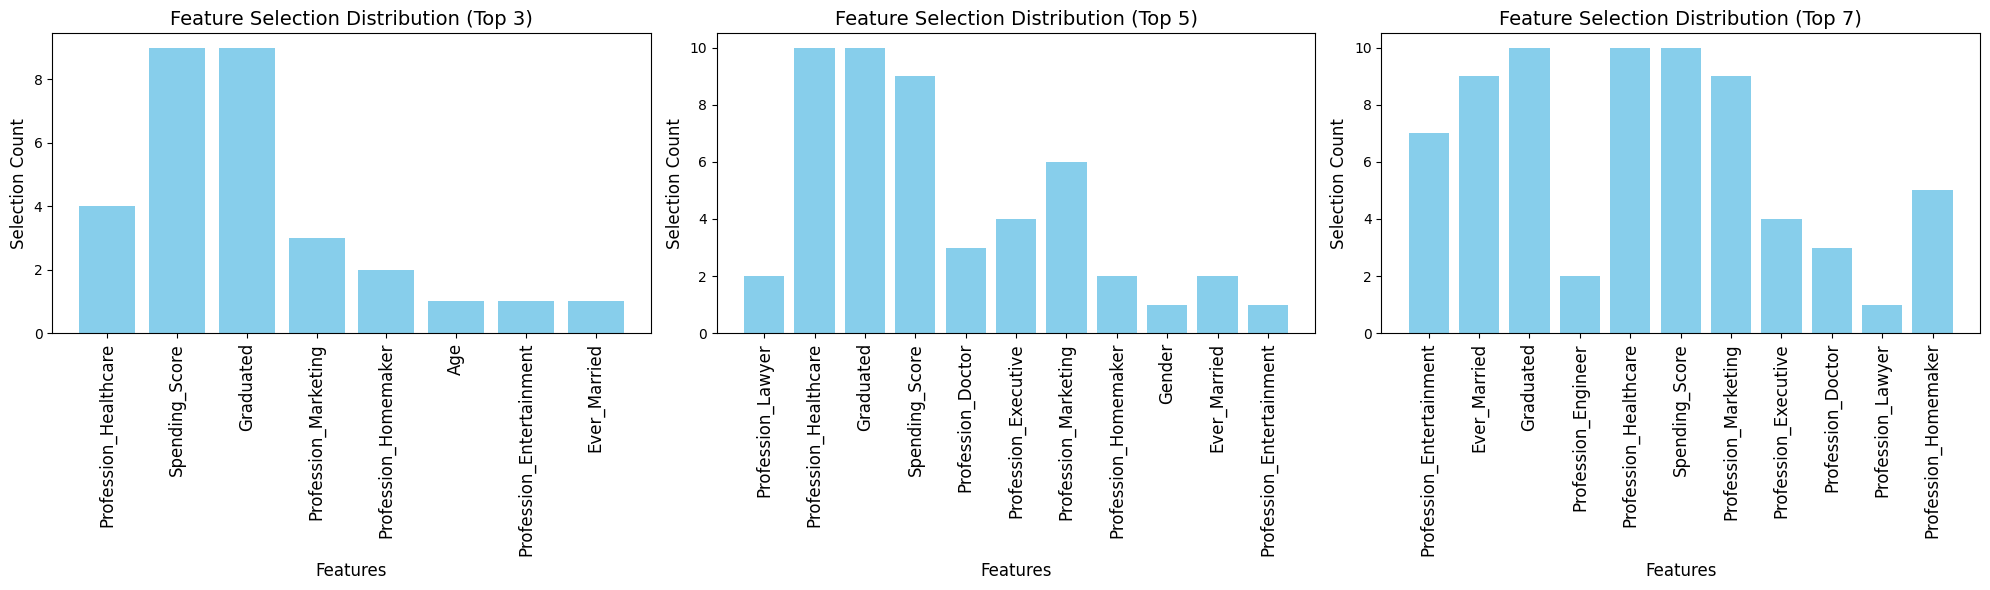

In [193]:
import matplotlib.pyplot as plt

# Plot feature selection distribution
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, size in enumerate(feature_sizes):
    feature_counts = feature_counts_dict[size]
    features, counts = zip(*feature_counts.items())

    axes[i].bar(features, counts, color='skyblue')
    axes[i].set_title(f"Feature Selection Distribution (Top {size})", fontsize=14)
    axes[i].set_xlabel("Features", fontsize=12)
    axes[i].set_ylabel("Selection Count", fontsize=12)
    axes[i].tick_params(axis='x', rotation=90, labelsize=12)  # Rotate labels for better readability

plt.tight_layout()
plt.show()



      Feature Set  Accuracy
0    All Features  0.421695
1  Top 3 Features  0.471864
2  Top 5 Features  0.501017
3  Top 7 Features  0.503051


<ipython-input-194-873ec10c45f9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Feature Set", y="Accuracy", data=df_results, palette="Blues_r")


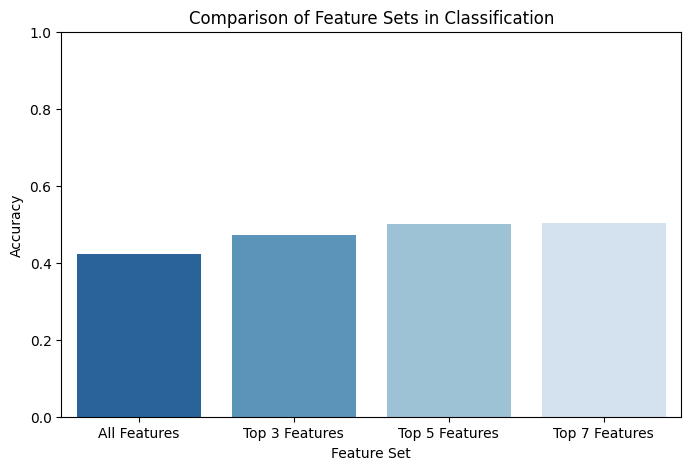

In [194]:
import pandas as pd
import seaborn as sns

# ایجاد DataFrame برای نتایج
df_results = pd.DataFrame(results.items(), columns=["Feature Set", "Accuracy"])

# نمایش جدول
print(df_results)

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(8, 5))
sns.barplot(x="Feature Set", y="Accuracy", data=df_results, palette="Blues_r")
plt.xlabel("Feature Set")
plt.ylabel("Accuracy")
plt.title("Comparison of Feature Sets in Classification")
plt.ylim(0, 1)
plt.show()
